In [1]:
# Import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

import prepare, model

In [6]:
# Load train, target and test datasets

X_train = pd.read_csv('train_features.csv', index_col=0)
Y_train = pd.read_csv('train_targets_scored.csv', index_col=0)
X_test = pd.read_csv('test_features.csv', index_col=0)

# Print their shapes
X_train.shape, Y_train.shape, X_test.shape # Correct

((23814, 875), (23814, 206), (3982, 875))

In [9]:
# Take the top 5 labels from Y_train

y_train = Y_train.loc[:, 'cyclooxygenase_inhibitor']

# Print the size of y_train
print(y_train.size)

# Take a peek at y_train
y_train[:5]

23814


sig_id
id_000644bb2    0
id_000779bfc    0
id_000a6266a    0
id_0015fd391    0
id_001626bd3    0
Name: cyclooxygenase_inhibitor, dtype: int64

In [10]:
# Concat to X_train and rename to df

df = pd.concat([X_train, y_train], axis=1)

# Print the shape
print(df.shape)

# Take a peek at the dataframe
df.head() # Success

(23814, 876)


,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cyclooxygenase_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,0
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,0
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0


### Preprocess

In [11]:
# Drop the categorical variables

df.drop(columns=['cp_type', 'cp_time', 'cp_dose'], inplace=True)
df.shape # 872 features left + 1 target

(23814, 873)

In [12]:
# Split the data into scaled train/validate/test
train, validate, test = prepare.split_stratify_my_data(df, 'cyclooxygenase_inhibitor')

# Print their shapes
train.shape, validate.shape, test.shape

((17145, 873), (4287, 873), (2382, 873))

In [13]:
# Seperate features and target on train

X_train = train.drop(columns='cyclooxygenase_inhibitor')
y_train = train.loc[:, 'cyclooxygenase_inhibitor']

# Print their shapes
X_train.shape, y_train.shape

((17145, 872), (17145,))

In [14]:
# Seperate features and target on valvalidate

X_validate = validate.drop(columns='cyclooxygenase_inhibitor')
y_validate = validate.loc[:, 'cyclooxygenase_inhibitor']

# Print their shapes
X_validate.shape, y_validate.shape

((4287, 872), (4287,))

In [15]:
# Seperate features and target on test

X_test = test.drop(columns='cyclooxygenase_inhibitor')
y_test = test.loc[:, 'cyclooxygenase_inhibitor']

# Print their shapes
X_test.shape, y_test.shape

((2382, 872), (2382,))

In [20]:
# Scale the datasets by StandardScaler

cols_to_scale = X_train.columns.to_list()
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_standard(X_train, 
                                                                                  X_validate, 
                                                                                  X_test, 
                                                                                  cols_to_scale)

# Print their shapes
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((17145, 872), (4287, 872), (2382, 872))

In [22]:
# Print the scaler
scaler

StandardScaler()

In [21]:
# Take a peek at scaled features
X_train_scaled.head()

,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,g-5_scaled,g-6_scaled,g-7_scaled,g-8_scaled,g-9_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_848dcc064,-0.991300,-1.125229,-0.308003,0.824555,0.280563,-0.012223,-1.136036,0.293466,-0.192251,0.888608,...,0.528685,0.614481,0.228145,0.616418,0.210893,0.775420,0.284549,0.733088,0.284447,0.417450
id_b9ce40651,-0.732383,-0.826175,-1.144797,-0.104080,-0.568048,-0.378395,-0.653489,0.031804,0.095541,0.678979,...,0.348094,0.302746,0.088366,0.320320,0.469363,-0.075580,0.461567,0.615178,0.460695,0.618914
id_a23c124dd,-0.176895,0.005618,-0.287764,0.499643,0.121631,0.773556,-1.344098,-0.063084,0.108267,0.538245,...,0.528132,0.697227,0.170625,0.500837,-0.185143,0.200777,0.757519,0.433231,-0.188280,-1.124558
id_632f29352,-0.401023,-0.063545,0.175523,0.456069,-1.146611,1.180902,0.924720,-0.459351,0.424365,0.698755,...,0.425031,0.721781,-0.657891,0.709415,0.083027,0.460765,0.558599,0.167272,-0.151084,0.301810
id_db60af3c3,-0.645767,-1.152160,-0.609379,0.981590,-0.604373,0.181305,-0.559673,-0.218176,0.646986,1.001747,...,1.026416,0.307755,0.745879,0.213411,0.293971,0.574051,0.352831,0.984536,0.595533,0.694943


In [25]:
# Check the variance of the scaled features
X_train_scaled.var(axis=0) # Checked: should be 1 from begining to the end

g-0_scaled     1.000058
g-1_scaled     1.000058
g-2_scaled     1.000058
g-3_scaled     1.000058
g-4_scaled     1.000058
                 ...   
c-95_scaled    1.000058
c-96_scaled    1.000058
c-97_scaled    1.000058
c-98_scaled    1.000058
c-99_scaled    1.000058
Length: 872, dtype: float64

### Create PCA features

In [26]:
# Create the PCA object

pca = PCA(n_components=10)
pca

PCA(n_components=10)

In [28]:
# Fit on train
pca.fit(X_train_scaled)

# Transform train
X_train_pca = pca.transform(X_train_scaled)

# Check the shape of X_pca
X_train_pca.shape

(17145, 10)

In [29]:
# Transform validate and test
X_validate_pca = pca.transform(X_validate_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the shape of X_pca
X_validate_pca.shape, X_test_pca.shape

((4287, 10), (2382, 10))

In [33]:
# Convert back to dataframe

X_train_pca = pd.DataFrame(X_train_pca, index=X_train_scaled.index)
X_validate_pca = pd.DataFrame(X_validate_pca, index=X_validate_scaled.index)
X_test_pca = pd.DataFrame(X_test_pca, index=X_test_scaled.index)

# Print their shape
X_train_pca.shape, X_validate_pca.shape, X_test_pca.shape

((17145, 10), (4287, 10), (2382, 10))

In [34]:
# Take a peek at X_train_pca
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9
sig_id,,,,,,,,,,
id_848dcc064,-7.371015,1.628876,3.343639,0.138077,0.600747,-0.409688,-2.054005,-0.444662,2.269145,1.767349
id_b9ce40651,-5.960171,0.455373,3.187833,-0.075677,1.532406,-5.339454,-1.012930,-1.814829,-3.096348,5.526629
id_a23c124dd,-2.218760,-0.199029,-2.925112,-3.265438,0.303465,-3.370315,1.339054,1.895301,-0.198379,-1.241937
id_632f29352,-6.837655,1.056420,2.588132,4.919355,2.172239,3.475701,-1.712311,1.021830,5.083321,1.416456
id_db60af3c3,-6.837025,-0.308337,-1.308055,3.997479,1.476960,2.143297,-0.961271,0.011352,1.137804,-1.989881


### Set up the baseline

In [36]:
y_train.value_counts(normalize=True)

0    0.981744
1    0.018256
Name: cyclooxygenase_inhibitor, dtype: float64

### Model on Train

In [37]:
# Use the Neutral Net as the classifier

mlp = MLPClassifier(random_state=123)
mlp

MLPClassifier(random_state=123)

In [38]:
# Fit on train
mlp.fit(X_train_pca, y_train)

# Print out the attributes
print(mlp.classes_)
print(mlp.n_layers_)
print(mlp.n_outputs_)
print(mlp.out_activation_)

[0 1]
3
1
logistic


In [39]:
# Make prediction
y_pred = mlp.predict(X_train_pca)

# Print the confusion matrix
confusion_matrix(y_train, y_pred)

array([[16831,     1],
       [  301,    12]])

In [41]:
# Print the report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16832
           1       0.92      0.04      0.07       313

    accuracy                           0.98     17145
   macro avg       0.95      0.52      0.53     17145
weighted avg       0.98      0.98      0.97     17145



### Model on validate

In [43]:
# Make prediction
y_pred = mlp.predict(X_validate_pca)

# Print the confusion matrix
confusion_matrix(y_validate, y_pred)

array([[4205,    4],
       [  78,    0]])

In [45]:
# Print the report
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4209
           1       0.00      0.00      0.00        78

    accuracy                           0.98      4287
   macro avg       0.49      0.50      0.50      4287
weighted avg       0.96      0.98      0.97      4287



### Model on test

In [46]:
# Make prediction
y_pred = mlp.predict(X_test_pca)

# Print the confusion matrix
confusion_matrix(y_test, y_pred)

array([[2336,    2],
       [  44,    0]])

In [47]:
# Print the report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2338
           1       0.00      0.00      0.00        44

    accuracy                           0.98      2382
   macro avg       0.49      0.50      0.50      2382
weighted avg       0.96      0.98      0.97      2382



**Summary**
- The principle components have been used as the new features to classify MoA annotation cyclooxygenase_inhibitor.
- Neutral Net by default is used as the classfiers. 
- Precision, Recall and f1-score are used as the metrics.
- The model performs very poor for such imbalanced data. The precision, recall, and f1-score are almost zero.

### Visualization by 1st and 2nd principle components

In [50]:
# Concat features and target

train_pca = pd.concat([X_train_pca, y_train], axis=1)
validate_pca = pd.concat([X_validate_pca, y_validate], axis=1)
test_pca = pd.concat([X_test_pca, y_test], axis=1)

In [51]:
# Take a peek at train_pca
train_pca.head()

,0,1,2,3,4,5,6,7,8,9,cyclooxygenase_inhibitor
sig_id,,,,,,,,,,,
id_848dcc064,-7.371015,1.628876,3.343639,0.138077,0.600747,-0.409688,-2.054005,-0.444662,2.269145,1.767349,0
id_b9ce40651,-5.960171,0.455373,3.187833,-0.075677,1.532406,-5.339454,-1.012930,-1.814829,-3.096348,5.526629,0
id_a23c124dd,-2.218760,-0.199029,-2.925112,-3.265438,0.303465,-3.370315,1.339054,1.895301,-0.198379,-1.241937,0
id_632f29352,-6.837655,1.056420,2.588132,4.919355,2.172239,3.475701,-1.712311,1.021830,5.083321,1.416456,0
id_db60af3c3,-6.837025,-0.308337,-1.308055,3.997479,1.476960,2.143297,-0.961271,0.011352,1.137804,-1.989881,0


In [62]:
train_pca.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'cyclooxygenase_inhibitor'], dtype='object')

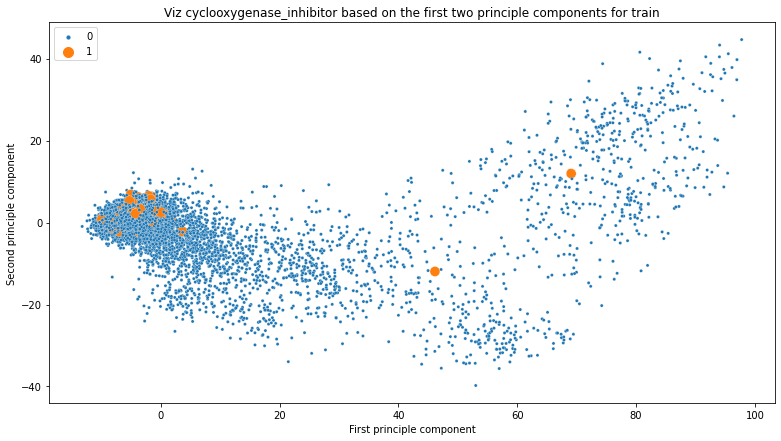

In [65]:
# Viz train based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=train_pca.loc[:, 0], y=train_pca.loc[:, 1], 
                hue=train_pca['cyclooxygenase_inhibitor'], 
                size=train_pca['cyclooxygenase_inhibitor'],
                sizes=(100, 10))

plt.title('Viz cyclooxygenase_inhibitor based on the first two principle components for train')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

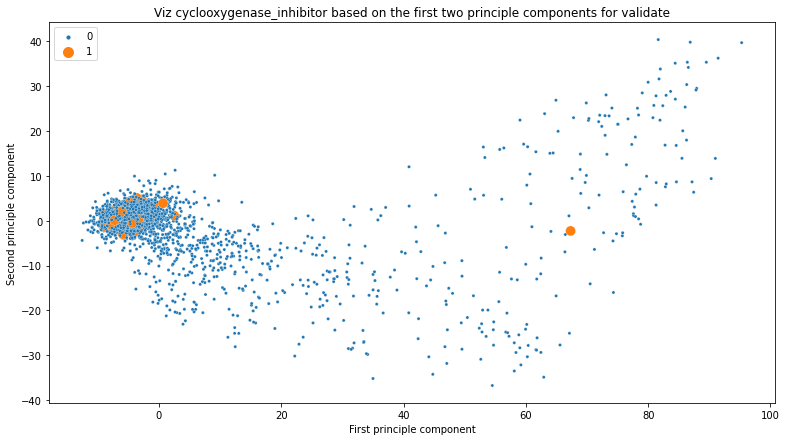

In [66]:
# Viz validate based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=validate_pca.loc[:, 0], y=validate_pca.loc[:, 1], 
                hue=validate_pca['cyclooxygenase_inhibitor'], 
                size=validate_pca['cyclooxygenase_inhibitor'],
                sizes=(100, 10))

plt.title('Viz cyclooxygenase_inhibitor based on the first two principle components for validate')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

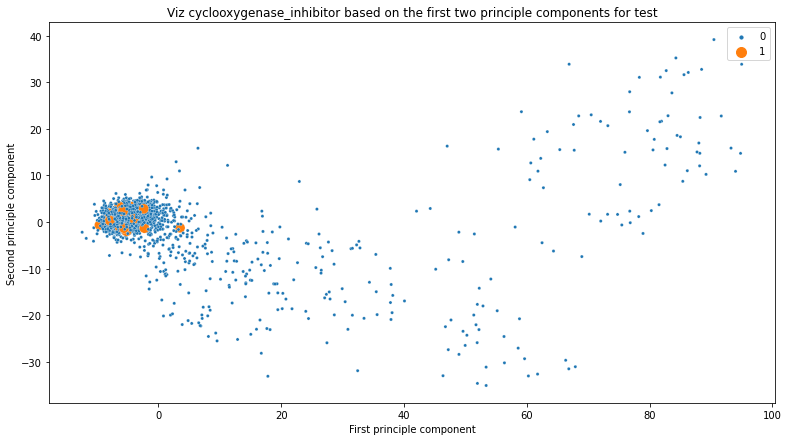

In [68]:
# Viz test based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=test_pca.loc[:, 0], y=test_pca.loc[:, 1], 
                hue=test_pca['cyclooxygenase_inhibitor'], 
                size=test_pca['cyclooxygenase_inhibitor'],
                sizes=(100, 10))

plt.title('Viz cyclooxygenase_inhibitor based on the first two principle components for test')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

**Takeaways**
- Visualiztion by the first two principle components reveals that the positives just buried in the sea of the negatives.